# Szöveges dokumentumok osztályozása
Olvasd el a [szövegbányászat](https://inf.u-szeged.hu/~rfarkas/ML20/NLP.html) előadás olvasóleckét.

Építsünk egy osztályozó gépi tanuló algoritmust, amit tanítunk, majd képes lesz korábban nem látott szövegekről döntést hozni, hogy azok pozitív, negatív vagy semleges véleményt fejeznek-e ki!

Töltsük le a tanító adatbázist:

In [ ]:
import pandas as pd
train_data = pd.read_csv('https://github.com/rfarkas/student_data/raw/main/sentiment/train.tsv')
train_data

ParserError: ignored

Hibaüzent :( Mi a hiba?

Ha a fájlt megnyitjuk akokr látjuk, hogy 3 oszlopot tartalmaz tabbal elválasztva (ezért tsv a kiterjesztés). A pandas.read_csv alapesetben vesszővel elválasztva várja a mezőket.

'Expected 2 fields in line 10, saw 4' Az első sor alapján a read_csv úgy gondolta, hogy két oszlop lesz, de a 10. sorban 4 oszlopot talált mert ott vesszők szerepeltek a szövegben...

**Érdemes rápillantani egy input filera mielőtt feldolgozni kezdjük!** 

In [ ]:
# ha a read_csv-nek megadjuk, hogy tab a separator akkor minden helyesen működik
train_data = pd.read_csv('https://github.com/rfarkas/student_data/raw/main/sentiment/train.tsv', sep='\t')
train_data

Értsük meg mi van az adatbázisban! Például milyen címkék (label) találhatóak benne?

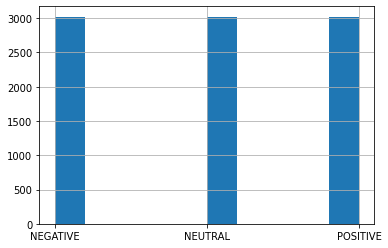

In [ ]:
train_data.label.hist()

## Szózsák jellemzőtér

A dokumentumok lesznek a gépi tanulásban az egyedek. A legegyszerűbb jellemzőkészket amivel reprezentálni lehet egy dokumentumot az az egyes dokumentumban előforduló szavak gyakorisága. Minden az adatbázisban előforduló szóra felveszünk egy jellemzőt. Tfh az 'alma' szó szerepel a szótárunkban. Ekkor ha a dokumentumban kétszer fordul elő, akkor a jellemző értéke 2 lesz, ha pedig nem fordul elő akkor 0.

Ezt **szózsák reprezentációnak**nek (bag-of-words) is hívják, mivel olyan mintha a szavakat beöntenénk egy zsákba, elveszik azok sorrendisége (pl. nem mindegy 'not' és 'good' szavak egymás után fordultak-e elő) és pozíciója. De első gépi tanulási kísérletre pont jó :)

Az `sklearn`ben a szózsákot a `CountVectorizer` jelemzőkinyerő implementálja. Ez leszámolja a dokumentumok szavait és azokat `sklearn` jellemzőkké (feature) alakítja. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10)

In [ ]:
# fit: összegyűjti a szótárat, azaz minden tokent ami legalább egyszer előfordul az adatbázisban
vectorizer.fit(train_data.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
len(vectorizer.get_feature_names())

24285

In [ ]:
vectorizer.vocabulary_ #ua, de itt a "szótár" a jellemzőtér

In [ ]:
# transform: végrehajtja a jellemzőkinyerést, azaz minden dokumentumhoz leszámolja minden szótárbeli szó gyakoriságát
features = vectorizer.transform(train_data.text)
features

<9063x24285 sparse matrix of type '<class 'numpy.int64'>'
	with 147011 stored elements in Compressed Sparse Row format>

A tanító adatbázisunk így 9063 egyedet tartalmaz (sorok) és 24285 jellemzőt (oszlopot). Azaz 24285 különböző token alkotja a szótárat. Mivel egy dokumentumban nagyon kevés szó fordul elő a 24285 szóból, ezért a jellemző mátrix túlnyomó része 0 lenne. Memória és futásidő okokból nem tároljuk az egész mátrixot hanem csak a nem 0 elemeket (azaz pozíció-érték párok listáját). Ezt hívjuk ritka (sparse) mátrixnak.

In [ ]:
# fit_transform: a fit és transform egymás után futtatva
features = vectorizer.fit_transform(train_data.text)
features

<9063x1880 sparse matrix of type '<class 'numpy.int64'>'
	with 108862 stored elements in Compressed Sparse Row format>

## Lineáris gépek

**Tanítunk** egy ún. [lineáris gép osztályozó](https://inf.u-szeged.hu/~rfarkas/ML20/linearis_gep.html) modellt, a [stochastic gradient descend (SGD)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html). Itt az elöző órán megismert döntési fát nem szerencsés használni mert nagyon sok jellemzőnk van és azok között megtanulni a kapcsolatot nagyon sok idő. Ilyenkor [lineáris osztályozókat](https://scikit-learn.org/stable/modules/linear_model.html) (SGD mellett például Logisztikus Regresszió) érdemes használni vagy olyan döntési fa variánsokat amik sok jellemzőre lettek kitalálva (pl. [xgboost](https://xgboost.readthedocs.io/)).

In [ ]:
from sklearn.linear_model import SGDClassifier

cls = SGDClassifier()

# a features a tanító adatbázis egyedeinek jellemzőreprezentációja, ami ugyanolyan hosszú, mint a címkevektor (a célváltozó ami a tanító példa)
model = cls.fit(features, train_data.label)
# a model a betanított rendszer ami képes korábban nem látott egyedekre is predikálni

In [ ]:
model.coef_

array([[-0.04225882,  0.25355291,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.16927348, -0.4231837 , -0.25391022, ..., -0.11284899,
        -0.11284899,  0.19748572],
       [-0.02501432,  0.35020049,  0.15008592, ...,  0.1250716 ,
         0.1250716 , -0.15008592]])

Az egyes osztályok legerősebb jellemzői:

In [ ]:
sorted(zip(model.coef_[0], vectorizer.get_feature_names()),reverse=True)[:15]

**Értékeljük ki**, hogy milyen pontos modellt tanítottunk ezen az adatbázison!

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
prediction = model.predict(features)
prediction # a predikció eredménye egy lista az egyedekre predikált címkékkel

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE', ..., 'POSITIVE', 'NEGATIVE',
       'NEUTRAL'], dtype='<U8')

Hasonlítsuk össze a predikált címkéket az adatbázisban szereplő helyes megoldásokkal! Az **accuracy** (pontosság) azt fejezi ki, hogy az esetek hány százalékában találta el a modell a helyes megoldást:

In [ ]:
accuracy_score(y_true=train_data.label, y_pred=prediction)

0.9917245945051307

In [ ]:
print(classification_report(y_true=train_data.label, y_pred=prediction))

              precision    recall  f1-score   support

    NEGATIVE       1.00      0.99      0.99      3021
     NEUTRAL       0.99      0.99      0.99      3021
    POSITIVE       0.99      0.99      0.99      3021

    accuracy                           0.99      9063
   macro avg       0.99      0.99      0.99      9063
weighted avg       0.99      0.99      0.99      9063



Örülünk, hogy 99.1% accuracyt értünk el fentebb !?

Nem. Még nem. 

Eddig a tanító adatbázison értékeltük ki a modellt, azaz azon amin tanítottuk. Így sérül az, hogy ismeretlen, korábban nem látott példákon kell jól működnie a modellnek. Az igazi kiértékelést egy olyan (hold-out) halmazon kell végrehajtani ami nem része a tanító adatbázisnak, ezt **kiértékelő adatbázis**nak hívjuk (evaluation vagy test set).

Megjegyzés: a tanító adatbázison való kiértékelésnek is van haszna. Ha nagyon alacsony értékeket kapunk az azt jelenti, hogy vagy jellemzőkészlet amit kinyertünk nem tartalmaz a tanuláshoz elég információt vagy a gépi tanuló modellt rosszul választottuk meg.

In [ ]:
test_data = pd.read_csv('https://raw.githubusercontent.com/rfarkas/student_data/main/sentiment/test.tsv', sep='\t')

In [ ]:
vectorizer2 = CountVectorizer()
test_features = vectorizer2.fit_transform(test_data.text)
prediction = model.predict(test_features)

ValueError: ignored

Hibaüzenet :( Már megint...

`'X has 7271 features per sample; expecting 24285'`

Emlékezzünk vissza, hogy a `vectorizer.fit_transform` `fit`je először az adatbázisból elkészíti a szótárat (legalább egyszer előforduló szavak az egész adatbázisban). A test adatbázisban 7271 különböző szó fordult elő. Így a test adatbázis jellemzőkészlete (`test_features`) nem kompatibilis a `model` jellemzőkészletével ami 24285 dimenziós. Fontos, hogy a tanító adatbázison kialakított jellemzőkészletet használjuk a test adatbázison is!

In [ ]:
test_features = vectorizer.transform(test_data.text) # a vectorizer a train-en fit-elt jellemzőkészletet tartalmazza, ezzel kell transform-álni a test nyers szövegeket
prediction = model.predict(test_features)

In [ ]:
accuracy_score(y_true=test_data.label, y_pred=prediction)

0.7646666666666667

A legegyszerűbb predikciós szabály az, hogy mindig a leggyakoribb címkét "predikáljuk". Jelen esetben akkor az accuracy 0.333 lenne, úgyhogy kijelenthetjük, hogy a modell tanult valamit :) 

De azért a baseline-t mérjük ki hivatalosan is:

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent") # tanító adatbázis leggyakoribb osztálya lesz mindig a predikció
dummy_clf.fit(features, train_data.label) # ugyanazon a tanító adatbázison "tanítjuk"
baseline_prediction = dummy_clf.predict(test_features) # predikció a kiértékelő adatbázison
accuracy_score(baseline_prediction, test_data.label)

0.3333333333333333

In [ ]:
## Az SGDClassifier-ben a loss és az alpha beállításával tudjuk elkerülni a túltanulást
## Ezt hívjuk regularizációnak lineáris gépeknél
cls = SGDClassifier(alpha=0.001)
model = cls.fit(features, train_data.label)
prediction = model.predict(test_features)
accuracy_score(y_true=test_data.label, y_pred=prediction)

0.7853333333333333

In [ ]:
from sklearn.tree import DecisionTreeClassifier
cls = DecisionTreeClassifier()
model = cls.fit(features, train_data.label)
prediction = model.predict(test_features)
accuracy_score(y_true=test_data.label, y_pred=prediction)

0.7513333333333333

## Tévesztési mátrix

In [ ]:
print(classification_report(y_true=test_data.label, y_pred=prediction))

              precision    recall  f1-score   support

    NEGATIVE       0.90      0.82      0.86       500
     NEUTRAL       0.70      0.71      0.71       500
    POSITIVE       0.68      0.72      0.70       500

    accuracy                           0.75      1500
   macro avg       0.76      0.75      0.75      1500
weighted avg       0.76      0.75      0.75      1500



Látszik, hogy a negatív osztályt valamiért könnyebben megtanulja, mind a precision, mind a recall jobb ott, mint a másik két osztályon...

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=test_data.label, y_pred=prediction)

array([[411,  36,  53],
       [ 24, 357, 119],
       [ 24, 117, 359]])

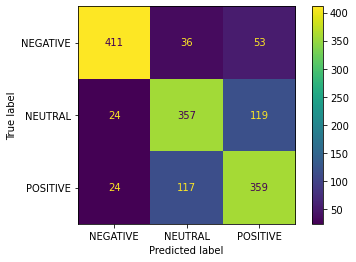

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true=test_data.label, y_pred=prediction)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='.3g')

A pozitív és semleges osztályokat valamiért sokszor összekeveri... Nézzünk rá példákat a tanító adatbázison!

# Modell javítása új jellemzőkészlettel

Ha a szavak mellett szópárok (bigram) is jellemzők lennének, több információt adunk át a modellnek. Így például a 'not good' megjelenik jellemzőként és esélyt adunk a modellnek, hogy összefüggést tanuljon rá.

In [ ]:
# CountVectorizernek átparaméterezésével új jellemzőkinyerést valósítunk meg, minden más ugyanaz marad
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1) 
# ngram_range mondja meg, hogy szavakat (unigram, 1gram) és egymás utáni szavakból álló párokat (bigram, 2gram) használjunk
# min_df=2 eldobja azokat a szavakat amik kevesebb, mint 2 dokumentumban fordult elő. Nagyon sok bigram van, ezzel csökkentjük a jellemzőkészlet dimenziószámát
# CountVectorizernek számos paramétere van, lásd: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

features_bigram = bigram_vectorizer.fit_transform(train_data.text)

cls = SGDClassifier() # új, üres osztályozó
model_bigram = cls.fit(features_bigram, train_data.label)
features_bigram

<9063x114650 sparse matrix of type '<class 'numpy.int64'>'
	with 312729 stored elements in Compressed Sparse Row format>

In [ ]:
bigram_vectorizer.vocabulary_

In [ ]:
prediction_bigram = model_bigram.predict(bigram_vectorizer.transform(test_data.text))

In [ ]:
print(accuracy_score(y_true=test_data.label, y_pred=prediction_bigram))
print(classification_report(y_true=test_data.label, y_pred=prediction_bigram))

Vannak olyan szavak amelyek sokszor fordulnak elő szövegekben, de szétválasztó erejük nincs, azaz ugyanúgy előfordulnak minden osztályban. Ilyenek például, sok más közt, a névelők. Ezek félreviszik az osztályozást (zajra tanulunk rá). A legegyszerűbb technika ennek kiküszöbölésére az ha a sima szógyakoriság (term frequency, TF) helyett normalizáljunk a szavak dokumentumok feletti gyakoriságávl (inverse document frequency, IDF). Lásd:  [TfIdf](http://www.tfidf.com)

In [ ]:
# TfidfTransformer is egy új ellemzőkinyersi mód, minden más változatlan
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = CountVectorizer()
cv_counts = vectorizer.fit_transform(train_data.text)
idf_transformer = TfidfTransformer(use_idf=True).fit(cv_counts)
features_idf = idf_transformer.transform(cv_counts)
features_idf

<9063x24285 sparse matrix of type '<class 'numpy.float64'>'
	with 147011 stored elements in Compressed Sparse Row format>

In [ ]:
cls = SGDClassifier()
model_idf = cls.fit(features_idf, train_data.label)

In [ ]:
prediction_idf = model_idf.predict(idf_transformer.transform(vectorizer.transform(test_data.text)))

In [ ]:
print(accuracy_score(y_true=test_data.label, y_pred=prediction_idf))
print(classification_report(y_true=test_data.label, y_pred=prediction_idf))

0.7906666666666666
              precision    recall  f1-score   support

    NEGATIVE       0.93      0.85      0.89       500
     NEUTRAL       0.75      0.73      0.74       500
    POSITIVE       0.71      0.79      0.75       500

    accuracy                           0.79      1500
   macro avg       0.80      0.79      0.79      1500
weighted avg       0.80      0.79      0.79      1500



Itt már kézzel fogható javulást tudtunk elérni.

# Model javítása előfeldolgozással

In [ ]:
def preprocess(textcol):
    return textcol.replace('\d+', 'NUM',regex=True)

In [ ]:
train_data.text = preprocess(train_data.text)
test_data.text  = preprocess(test_data.text)

In [ ]:
train_data.text

Az [NLTK](https://www.nltk.org/) az egyik leggyakrabban használt python csomag szövegfeldolgozásban. A másik a [spaCy](https://spacy.io/). Kettejük egy összehasonlítása [itt](https://www.activestate.com/blog/natural-language-processing-nltk-vs-spacy/)

In [ ]:
import nltk

Miért nem egyértelmű a tokenizálás? Miért léteznek különböző algoritmusok?

Azért mert különböző nyelveken másképp lehetnek a szóhatárok (magyar "-e"), például rövidítést jelentő pont a token része ("U.S.A." vagy "kft."), míg mondatvégi a írásjel nem. Továbbá a szöveg típusa is megkövetelhet különböző tokenizálókat, pl. szociális médiában az emotikonok és URLeket egyben kell tartni de a camelcase szavakat (pl. JoMunkahozIdoKell) tokenizáljuk, kémiai szövegekben a kötőjel egy molekula nevében nem szóhatár, stb.

In [ ]:
text = """What can I say about this place. The staff of the restaurant is nice and the eggplant is not bad. Apart from that, very uninspired food, lack of atmosphere and too expensive. I am a staunch vegetarian and was sorely dissapointed with the veggie options on the menu. Will be the last time I visit, I recommend others to avoid."""

nltk_splitter = nltk.data.load('tokenizers/punkt/english.pickle') # Számos szöveget mondatra bontó algoritmus (splitter) van implementálva az NLTKban. A Punkt az egyik, ezt betöltjük. 
nltk_tokenizer = nltk.tokenize.TreebankWordTokenizer() # Számos szavakra (tokenekre) bontó algoritmus (tokenizer) is implementálva van.

# text mondatai:
sentences = nltk_splitter.tokenize(text)

Sajnos ez így még nem működik. Az NLTK erőforrásfájlait külön le kell töltenünk a Colab-ba. Ha azok nincsenek ott hibaüzenettel elszállunk futtatás közben.

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

Most már működik! Futassuk újra a nltk_splitter inicializáló kódcellát!

In [ ]:
sentences = nltk_splitter.tokenize(text) # a szöveget mondatokra bontjuk
sentences # mondatokat tartalmazó lista

In [ ]:
tokenized_sentences = [nltk_tokenizer.tokenize(sent) for sent in sentences] # a mondatokat bejárjuk a for ciklussal és egyessével tokenizáljuk őket
tokenized_sentences # listák listája, amiben a mondatok szavai vannak

Egy másik fontos előfeldolgozási lépés a **szótövesítés (stemming, lemmatizáció)**. A cél, hogy a szavak különböző ragozott alakjait össze tudjuk vonni (pl. általában nem érdemes külön kezelni az 'asztalaitokra' és 'asztal' szóalakokat). A lemmatizáció az igazi nyelvtani értelemben vett szótő meghatározását jelenti. Ez nagyon bonyolult feladat tud lenni bizonyos nyelveken, pl. a magyarban ahol tőhangváltás is van (a 'madarak' szó szótöve a 'madár'). De sokszor elég a szótőnek egy "közelítése", azaz egyszerű szabályokkal lecseréljük a szóalak végi karaktereket más karakterre. Ezt a közelítő (butább, de sokkal egyszerűbb és gyorsabb) hívjuk stemmelésnek ([részletesen](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python))

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer # egy angol igazi lemmatizáló
nltk.download('wordnet') # erőforrást itt is le kell tölteni hozzá
lemmatizer = WordNetLemmatizer() 

In [ ]:
lemmatizer.lemmatize("companies")

In [ ]:
from nltk.stem import PorterStemmer # egy angol gyors stemmer (nincs erőforrásfájl, a szabályok a kódban vannk)
stemmer = PorterStemmer()

In [ ]:
stemmer.stem("companies") # 'es' végződés levágása sokszor működik többesszámú főneveknél. A 'companies' esetén "buta".

# Gyakorló feladatok

Az órai adatbázison hajts végre egy kísérletet (tanítás, predikció és kiértékelés) ahol

*   a szavak szótövét vagy stemjét használjuk a szózsák modellben!
*   egy másik lineáris gépet, a Logisztkus Regresszió osztályozó algoritmust használunk (Logistic Regression Classifier).

Írd ki, hogy mekkora szótár lesz így illetve mennyi így az accuracy!

---
**Kitekintés:**
Az elmúlt években a szózsák modellt felváltották a szóbeágyazás alapú reprezentációk, pl. [word2vec](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial) illetve a deep learning osztályozók, konvolúciós és rekurrens neurális hálózatok. És aki mindent visz 2019 óta az [BERT](https://towardsdatascience.com/nlp-extract-contextualized-word-embeddings-from-bert-keras-tf-67ef29f60a7b)...
